In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import random
import time
from joblib import Parallel, delayed
sys.path.append('../')

from packages import actv_analysis, svm
import seaborn as sns

In [7]:
# Parameters
relus = list(range(4, 5))
epochs = np.arange(0, 91, 10)
num_units = 200
layer_numunits = {'relu1':290400, 'relu2':186624, 'relu3':64896, 'relu4':64896, 'relu5':43264}

dir_path = os.path.dirname(os.path.realpath('..'))
save_to_folder = f"{dir_path}/dataframes/SVM_predictions"

exps = range(10)
percentage_true_values = np.arange(0, 1.1, 0.1)

for relu in relus:
    for epoch in [90]:
        for net in range(1, 4):
            
            pkl_filename = f'../../pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'
            print(f'Loading {pkl_filename}..')
            with open(pkl_filename, 'rb') as f:
                units = pickle.load(f)
                    
            print(f'Loading actv ..')
            actv_net = actv_analysis.get_actv_net(net=net, relu=relu, epoch=epoch)
            actv = actv_net.reshape(layer_numunits[f'relu{relu}'], 10, 10, 500)
                    
            for percentage_true in percentage_true_values:

                random_units = svm.get_random_units(units, num_units=num_units, sort_by='ktau', percentage_true=percentage_true, 
                                                    upper_bound={'Q1':(1, 1),'Q2': (-1, .2),'Q3': (-1, -1),'Q4': (1, -.2)}, Q1=True, Q3=True)

                start_time = time.time()
                y_preds = Parallel(n_jobs=-1)(delayed(svm.SVM_fit)(units=random_units, actv=actv, exp=exp) for exp in exps)
                end_time = time.time()
                print(f"Took {end_time - start_time} seconds to run.")

                for exp in exps:
                    filename = f'../../csv/SVM_prediction_He_untrained_net{net}_relu{relu}_epoch{epoch}_{num_units}_units_Q1_or_Q3_{percentage_true*100:.0f}percent_Q2Q4_abs_upper_bound02_exp{exp}_Oct2023.csv'
                    pd.Series(y_preds[exp]).to_csv(filename, index=True)
                    #print(f'Saved results to {filename}')

Loading ../../pkl/4to20/network1_Relu4_epoch90_4to20.pkl..
Loading actv ..
--- 98.33851385116577 seconds ---
Took 24.892332077026367 seconds to run.
Took 23.355629920959473 seconds to run.
Took 23.936364889144897 seconds to run.
Took 23.499849796295166 seconds to run.
Took 22.66719698905945 seconds to run.
Took 23.161978721618652 seconds to run.
Took 23.489341974258423 seconds to run.
Took 23.25684690475464 seconds to run.
Took 23.001152992248535 seconds to run.
Took 23.59546709060669 seconds to run.
Took 23.812267065048218 seconds to run.
Loading ../../pkl/4to20/network2_Relu4_epoch90_4to20.pkl..
Loading actv ..
--- 97.77795672416687 seconds ---
Took 24.09028935432434 seconds to run.
Took 22.34583306312561 seconds to run.
Took 22.440109729766846 seconds to run.
Took 23.122609853744507 seconds to run.
Took 22.65004801750183 seconds to run.
Took 22.75548505783081 seconds to run.
Took 23.656926155090332 seconds to run.
Took 22.43042826652527 seconds to run.
Took 23.954946041107178 second

In [10]:
net=1; relu=4; epoch=90
num_units=200
df_acc = pd.DataFrame(columns=['net','relu','epoch','percentage','exp','cong_acc','incong_acc'])

for net in range(1,11):
    for epoch in [90]:
        for percentage_true in np.arange(0,1.1,0.1):
            for exp in range(0,10):
    
                test_csv = f'../../csv/svm_test_set{exp}_4to20.csv'
                pred_csv = f'../../csv/SVM_prediction_He_untrained_net{net}_relu{relu}_epoch{epoch}_{num_units}_units_Q1_or_Q3_{percentage_true*100:.0f}percent_exp{exp}_Oct2023.csv'
                test_exp = pd.read_csv(test_csv, index_col=0)
                num_dists=np.abs(test_exp['num1']-test_exp['num2'])*2
                correct_answers = svm.get_y(test_exp).to_numpy()
                svm_answers = pd.read_csv(pred_csv)['0'].to_numpy()
                is_equal = np.equal(correct_answers, svm_answers)

                cong = test_exp.index[((test_exp['num1']<test_exp['num2'])&(test_exp['sz1']<test_exp['sz2']))|((test_exp['num1']>test_exp['num2'])&(test_exp['sz1']>test_exp['sz2']))]
                incong = np.setdiff1d(range(len(test_exp)), cong)
                incong_acc = np.sum(is_equal[incong])/len(is_equal[incong])
                cong_acc = np.sum(is_equal[cong])/len(is_equal[cong])
                info = [net,relu,epoch,percentage_true,exp,cong_acc,incong_acc]
                # Append info to df_acc
                df_acc = pd.concat([df_acc, pd.DataFrame([info], columns=df_acc.columns)], ignore_index=True)
                
df_acc['complement_percentage'] = 1 - df_acc['percentage']

# Save df_acc to a CSV file if needed
#df_acc.to_csv('Quadrants_svm_results.csv', index=False)

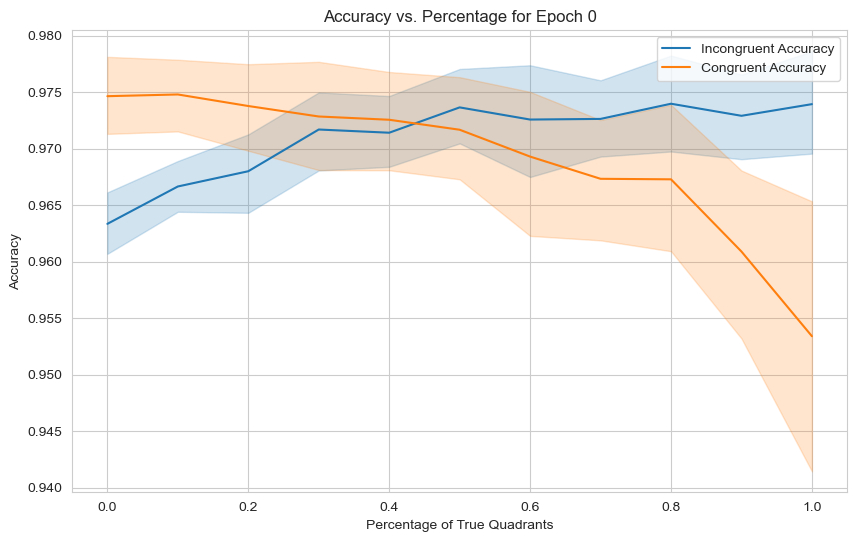

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

df_avg = df_acc.groupby(['net', 'relu', 'epoch', 'percentage', 'complement_percentage'])[['cong_acc', 'incong_acc']].mean().reset_index()

# Filter the DataFrame to include only rows where epoch is 0
df_epoch0 = df_avg[df_avg['epoch'] == 90]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the line plot for incong_acc
sns.lineplot(x='complement_percentage', y='incong_acc', data=df_epoch0, label='Incongruent Accuracy')

# Create the line plot for cong_acc
sns.lineplot(x='complement_percentage', y='cong_acc', data=df_epoch0, label='Congruent Accuracy')

# Customize the plot
plt.title('Accuracy vs. Percentage for Epoch 0')
plt.xlabel('Percentage of True Quadrants')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('Q2Q4_coeff2_abs_upper_bound_02.pdf')
plt.show()

## Supplementary: congruency-coding units

In [ ]:
net=1; relu=4; epoch=90

pkl_filename = f'../../pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'
print(f'Loading {pkl_filename}..')
with open(pkl_filename, 'rb') as f:
    units = pickle.load(f)